In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Build a function to extract training data from csv simulator run

In [2]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg


def extractor(log_path):
    df=pd.read_csv(log_path,names=['center','left','right','steering','throttle','brake','speed'])
    df=df[df['speed']>0]
    df['left_steering']=df['steering']+0.2
    df['right_steering']=df['steering']-0.2
    angles=df['steering'].values
    angles_left=df['left_steering'].values
    angles_right=df['right_steering'].values
    angles_array=np.concatenate([angles,angles_left,angles_right])

    image_data=np.concatenate([df['center'].values, df['left'].values, df['right'].values])
    image_data_array=np.array([mpimg.imread(i) for i in image_data])
    
    img_augment=[np.fliplr(i) for i in image_data_array]
    angle_augment=angles_array*-1
    
    angle_final=np.concatenate([angles_array,angle_augment])
    image_data_array_final=np.concatenate([image_data_array,img_augment])
    
    return image_data_array_final,angle_final    

In [3]:
def extractor2(log_path):
    df=pd.read_csv(log_path)
    df=df[df['speed']>0]
    df['left_steering']=df['steering']+0.2
    df['right_steering']=df['steering']-0.2
    
    angles=df['steering'].values
    angles_left=df['left_steering'].values
    angles_right=df['right_steering'].values
    
    angles_array=np.concatenate([angles,angles_right,angles_right])

    image_data=np.concatenate([df['center'].values, df['left'].values, df['right'].values])
    image_data_array=np.array([mpimg.imread(i) for i in image_data])
    
    img_augment=[np.fliplr(i) for i in image_data_array]
    angle_augment=angles_array*-1
    
    angle_final=np.concatenate([angles_array,angle_augment])
    image_data_array_final=np.concatenate([image_data_array,img_augment])
    
    return image_data_array_final,angle_final   

## Combine dataset from multiple stimulator run csv file

In [4]:
def combine(csv_list):
    x_dataset=[]
    y_dataset=[]
    
    for i in csv_list:
        x_data,y_data=extractor(i)
        x_dataset.append(x_data)
        y_dataset.append(y_data)
        
    combine_x=np.concatenate(x_dataset)
    combine_y=np.concatenate(y_dataset)
    
    return combine_x, combine_y       

In [5]:
csv_list=['E:\Projects\Self_driving_car\Project4\set3\driving_log.csv',
         'E:\Projects\Self_driving_car\Project4\set2\\driving_log.csv']

combine_x,combine_y=combine(csv_list)

In [6]:
xsuper,ysuper=extractor2('E:\\Projects\\Self_driving_car\\Project4\\udacityset\\udacity_driving_log_edit.csv')

In [7]:
image_data_array_final=np.concatenate([combine_x,xsuper])

In [9]:
angle_final=np.concatenate([combine_y,ysuper])

## Split the data

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(image_data_array_final,angle_final,test_size=0.2,random_state=0)

## Generator to draw img

In [11]:
import sklearn
from sklearn.utils import shuffle

def generator(x_samples,y_samples,batch_size):
    num_samples=len(x_samples)
    while True:
        sklearn.utils.shuffle(x_samples,y_samples)
        for i in range(0,num_samples,batch_size):
            x_batch_samples=x_samples[i:i+batch_size]
            y_batch_samples=y_samples[i:i+batch_size]
            yield x_batch_samples,y_batch_samples         

In [15]:
batch_size=64
train_generator = generator(x_train, y_train, batch_size=batch_size)
validation_generator =generator(x_valid,y_valid,batch_size=batch_size)

## Preprocessing

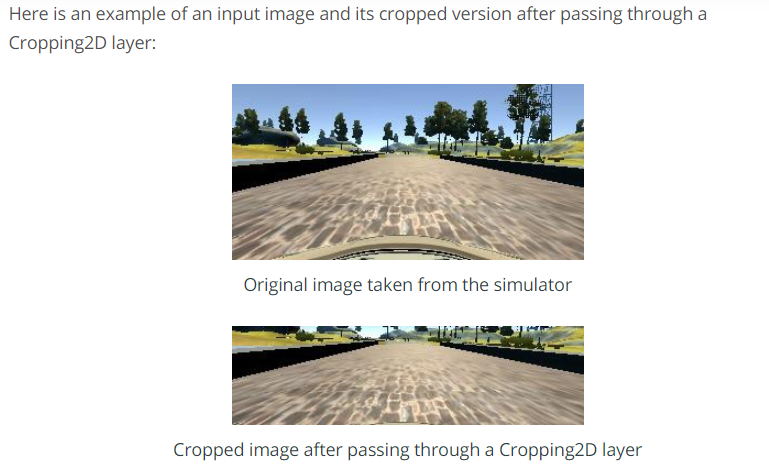

## Build the model

In [16]:
from keras.applications import ResNet50
conv_base=ResNet50(weights=None,include_top=False)
conv_base.summary() 

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Users\Patrick\Anaconda3\envs\main\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [17]:
from keras import layers
from keras import models
from keras.layers import Dense, Dropout, Flatten, Cropping2D, Lambda

model=models.Sequential()
model.add(Lambda(lambda x: (x / 255.) - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((50, 20), (0, 0))))

model.add(conv_base)
model.add(Flatten())
model.add(layers.Dropout(0.2))

model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(32))
model.add(layers.Dropout(0.1))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 61440)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61440)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               31457792  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

In [18]:
lr=0.0007
from keras import optimizers
model.compile(loss='mse',optimizer=optimizers.Adam(lr=lr))#,metrics=['mae', 'acc'])

In [19]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.h5',
                    save_best_only=True, save_weights_only=False ,monitor='val_loss',
                    mode='min', period=1,verbose=1)]

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 61440)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61440)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               31457792  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

## Load previous weight to continue training

In [21]:
model.load_weights('weights.08-0.01.h5')

In [22]:
train_sample_size=len(x_train)
print('Training sample size', train_sample_size)
valid_sample_size=len(x_valid)
print('Validation sample size', valid_sample_size)

classifier=model.fit_generator(train_generator,
                           steps_per_epoch=train_sample_size/batch_size,epochs=30,
                           validation_data=validation_generator,
                            validation_steps=valid_sample_size/batch_size,callbacks = callbacks)

Training sample size 71241
Validation sample size 17811
Epoch 1/30
1114/1113 [==============================] - 421s 378ms/step - loss: 0.0055 - val_loss: 0.0054

Epoch 00001: val_loss improved from inf to 0.00543, saving model to weights.01-0.01.h5
Epoch 2/30
1114/1113 [==============================] - 396s 355ms/step - loss: 0.0052 - val_loss: 0.0052

Epoch 00002: val_loss improved from 0.00543 to 0.00518, saving model to weights.02-0.01.h5
Epoch 3/30
1114/1113 [==============================] - 393s 352ms/step - loss: 0.0048 - val_loss: 0.0053

Epoch 00003: val_loss did not improve from 0.00518
Epoch 4/30
1114/1113 [==============================] - 390s 351ms/step - loss: 0.0045 - val_loss: 0.0054

Epoch 00004: val_loss did not improve from 0.00518
Epoch 5/30
1114/1113 [==============================] - 390s 350ms/step - loss: 0.0041 - val_loss: 0.0067

Epoch 00005: val_loss did not improve from 0.00518
Epoch 6/30
1114/1113 [==============================] - 392s 352ms/step - loss

KeyboardInterrupt: 

## KeyboardInterrupt becoz I manually stop the training

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='upper right')
plt.show()

## To inference the model in stimulator

In [ ]:
#python drive.py model.h5